# Checkpoint Objective
In this checkpoint, we are going to predict if a patient has chronic kidney disease or not using several classification algorithms of supervised learning. Then we will identify the inherent clusters within our data using clustering algorithms of unsupervised learning.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_score
import graphviz
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# Part1: supervised learning

#### 1. Load the dataset of kidney disease.

In [2]:
dt = pd.read_csv('26.kidney_disease_AmaniYch.csv')
dt

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,51,7200,5.9,no,no,no,good,no,no,notckd


Preprocessing

In [3]:
# Dropping id 
dt = dt.drop(['id'], axis = 1)

In [4]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             330 non-null    object 
 16  wc              295 non-null    object 
 17  rc              270 non-null    obj

In [5]:
dt.isnull().sum()

age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

Throughout observations, we noticed that there is an unknown symbol '\t' in the data, making some columns categorical

In [6]:
# Filter the rows that contain the exact sequence '\t' in any of the columns
rows_with_t = dt[dt.apply(lambda x: x.astype(str).str.contains(r'\t', na=False)).any(axis=1)]

# Remove rows containing '\t' in any part of their values
rows_with_t = dt.apply(lambda x: x.astype(str).str.contains(r'\t', regex=True)).any(axis=1)
dt = dt[~rows_with_t]

# Transform pcv, wc and rc columns into numerical ones
numeric_cols = ['pcv', 'wc', 'rc']
for col in numeric_cols:
    dt[col] = pd.to_numeric(dt[col])

Treating missing values for numerical columns

In [7]:
# Identify the numeric columns
num_cols = dt.select_dtypes(include=['int64', 'float64']).columns

# Impute missing values using KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed
dt[num_cols] = knn_imputer.fit_transform(dt[num_cols])

Treating missing values for categorical columns

We want to impute missing values in categorical columns by a random sampling from all the non-missing values in that column, with the probability of each category being proportional to its frequency (count) in the column. This way, the imputed values will reflect the distribution of the existing data.

In [8]:
# Identify the categorical columns
cat_cols = dt.select_dtypes(include=['object']).columns.to_list()

# Function to impute missing values with random sampling based on category frequencies
def impute_missing_with_random_sampling(column):
    non_missing_values = column.dropna()
    probabilities = non_missing_values.value_counts(normalize=True)
    return np.random.choice(probabilities.index, size=column.isnull().sum(), p=probabilities)

# Impute missing values in categorical columns using random sampling
for col in cat_cols:
    missing_mask = dt[col].isnull()
    dt.loc[missing_mask, col] = impute_missing_with_random_sampling(dt[col])

# Convert back to categorical data type
for col in cat_cols:
    dt[col] = dt[col].astype('object')

In [9]:
# Check for any remaining missing values
dt.isnull().sum().max()

0

Encoding categorical columns

In [10]:
# Encode the categorical columns
le = LabelEncoder()
for col in cat_cols:
    dt[col] = le.fit_transform(dt[col])

#### 2. Use this command to rename the columns:  
data.rename(columns={'bp': 'blood_pressure', 'sg': 'specific gravity','al':'albumin','su':'sugar','rbc':'red blood cells','pc':'pus cell','pcc':'pus cell clumps','ba':'bacteria','bgr':'blood glucose random','bu':'blood urea','sc':'serum creatinine','sod':'sodium','pot':'potassium','hemo':'hemoglobin','pcv':'packed cell volume','wc':'white blood cell count','rc':'red blood cell count','htn':'hypertension','dm':'diabetes mellitus','cad':'coronary artery disease','appet':'appetite','pe':'pedal edema','ane':'anemia','classification':'class'},inplace=True)

In [11]:
dt.rename(columns={'bp': 'blood_pressure', 'sg': 'specific gravity','al':'albumin','su':'sugar','rbc':'red blood cells',
                   'pc':'pus cell','pcc':'pus cell clumps','ba':'bacteria','bgr':'blood glucose random','bu':'blood urea',
                   'sc':'serum creatinine','sod':'sodium','pot':'potassium','hemo':'hemoglobin','pcv':'packed cell volume',
                   'wc':'white blood cell count','rc':'red blood cell count','htn':'hypertension','dm':'diabetes mellitus',
                   'cad':'coronary artery disease','appet':'appetite','pe':'pedal edema','ane':'anemia','classification':'class'},
                   inplace=True)

#### 3. Apply logistic regression, and print the confusion matrix to validate your model. 

In [12]:
# Seperate the data into features and target
x = dt.drop('class', axis = 1)
y = dt['class']

# Scale the features
ss = StandardScaler()
x = ss.fit_transform(x)

# Split the data into a training and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Fit the model
lr = LogisticRegression()
lr.fit(x_train, y_train)

# Get predictions
y_lr = lr.predict(x_test)

# Verify model with confusion matrix
conf_mtrx = confusion_matrix(y_test, y_lr)
print(f'Confusion matrix: \n{conf_mtrx}\n')

# Accuracy score 
accuracy_lr = accuracy_score(y_test, y_lr)
print(f'Accuracy score of Logistic Regression model: {accuracy_lr}')

Confusion matrix: 
[[46  1]
 [ 0 30]]

Accuracy score of Logistic Regression model: 0.987012987012987


#### 4. Apply KNN and choose the optimal number of neighbors

In [13]:
# Apply KNN
knn_grid = KNeighborsClassifier()

# Define a parameter grid for tuning the number of neighbors
param_grid = {'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11]}

# Use GridSearchCV to find the optimal number of neighbors
grid_search = GridSearchCV(knn_grid, param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Get the best estimator
best_knn = grid_search.best_estimator_

# fit the model according to the optimal k
knn = KNeighborsClassifier(n_neighbors=best_knn.n_neighbors)
knn.fit(x_train, y_train)

# Get predictions
y_knn = knn.predict(x_test)

# Accuracy score
accuracy_knn = accuracy_score(y_test, y_knn)
print(f'Accuracy score of knn model: {accuracy_knn}')

Accuracy score of knn model: 0.974025974025974


#### 5. Apply decision tree, plot it and calculate the accuracy.

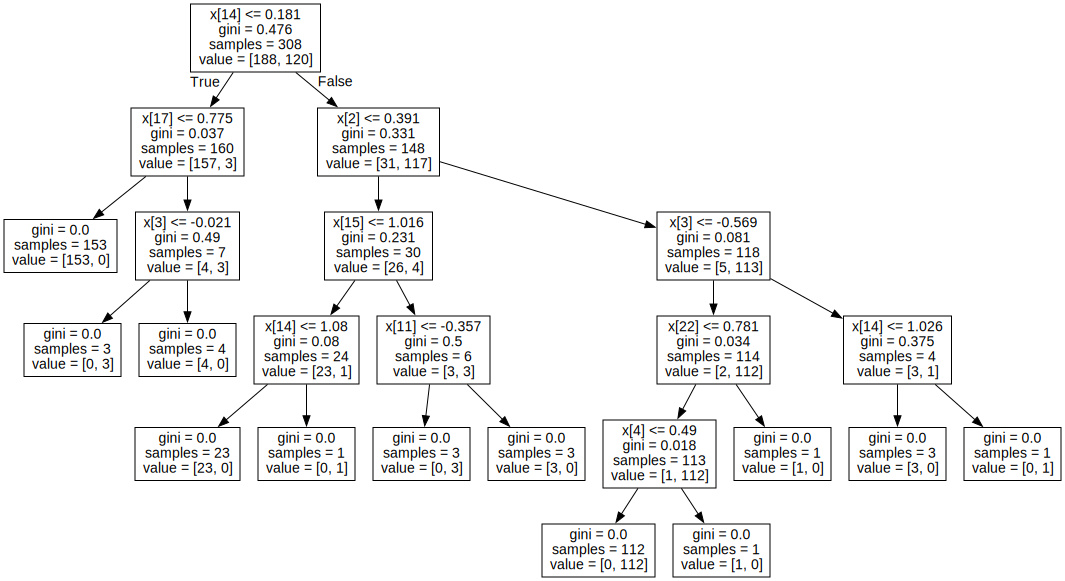

In [14]:
# Fit the model
dtc = DecisionTreeClassifier(random_state=123)
dtc.fit(x_train, y_train)

# Fit the model
dtc = DecisionTreeClassifier(random_state=123)
dtc.fit(x_train, y_train)

# Plot the Decision Tree
dot_data = tree.export_graphviz(dtc, out_file = None)
graph = graphviz.Source(dot_data)
graph.render('data')
graph

In [15]:
# Get predictions
y_dtc = dtc.predict(x_test)

# Calculate accuarcy
accuracy_dtc = accuracy_score(y_test, y_dtc)
print(f'Accuracy score of decision Tree model: {accuracy_dtc}')

Accuracy score of decision Tree model: 0.974025974025974


#### 6. Apply random forest, calculate the new accuracy and compare it with the previous result.

In [16]:
# Fit the model
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

# Get predictions
y_rfc = rfc.predict(x_test)

# Accuracy score
accuracy_rfc = accuracy_score(y_test, y_rfc)
print(f'Accuracy score of Random Forest Classifier model: {accuracy_rfc}')

Accuracy score of Random Forest Classifier model: 0.987012987012987


In [17]:
# compare the results
# Create a DataFrame to store the accuracy scores
data = {
    'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest'],
    'Accuracy': [accuracy_lr, accuracy_knn, accuracy_dtc, accuracy_rfc]
}
accuracy_df = pd.DataFrame(data)

# Sort the DataFrame by accuracy in descending order
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)

# Display the DataFrame
accuracy_df

,Model,Accuracy
0,Logistic Regression,0.987013
3,Random Forest,0.987013
1,KNN,0.974026
2,Decision Tree,0.974026


# Part2: unsupervised learning

#### 1. Drop out the target variable (named “classification”)

In [18]:
# We already have x scaled and void of class column

#### 2. Use hierarchical clustering to identify the inherent groupings within your data.

Plot the dendrogram

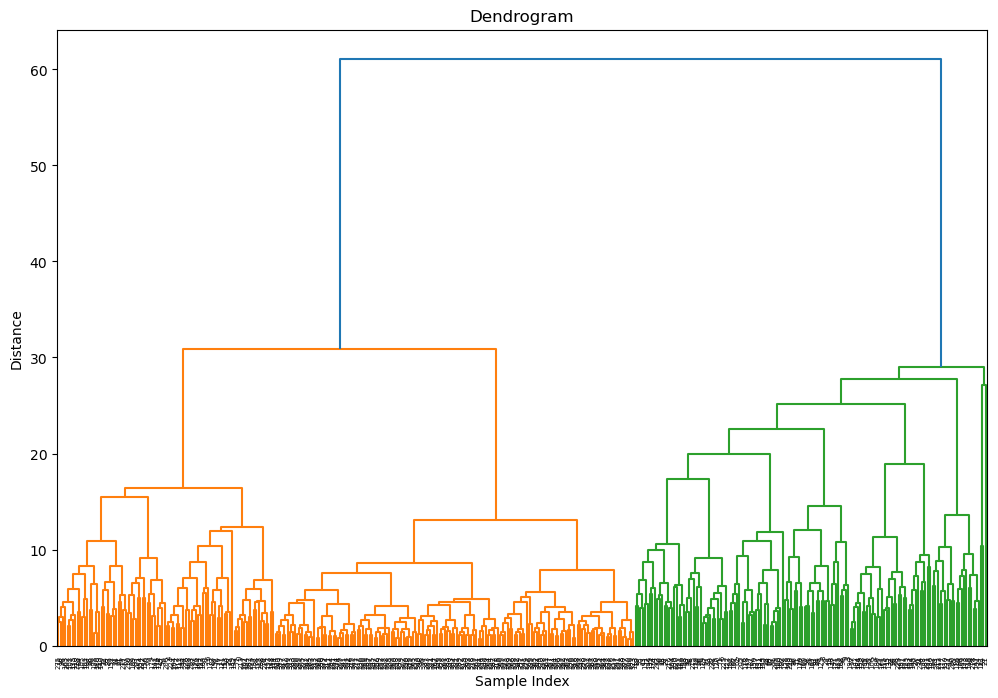

In [19]:
# Perform hierarchical clustering
linked = linkage(x, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title("Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

Apply agglomerative clustering

In [20]:
# Apply the model for n = 2
ac = AgglomerativeClustering(n_clusters=2, linkage = 'ward')
clust_ac = ac.fit_predict(x)

#### 3. Plot the clusters. 

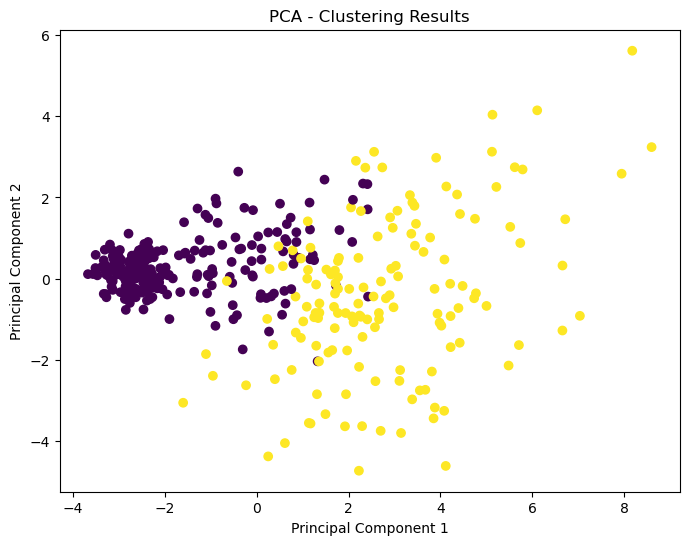

In [21]:
# Using PCA for dimension reduction
pca = PCA(n_components=2)
pca_lc = pca.fit_transform(x)

# Visualize the clustered data using a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_lc[:, 0], pca_lc[:, 1], c=clust_ac)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA - Clustering Results")
plt.show()

#### 4. Plot the dendrogram. Use k-means clustering and select the optimal k.

Use silhouette score to choose the optimal k

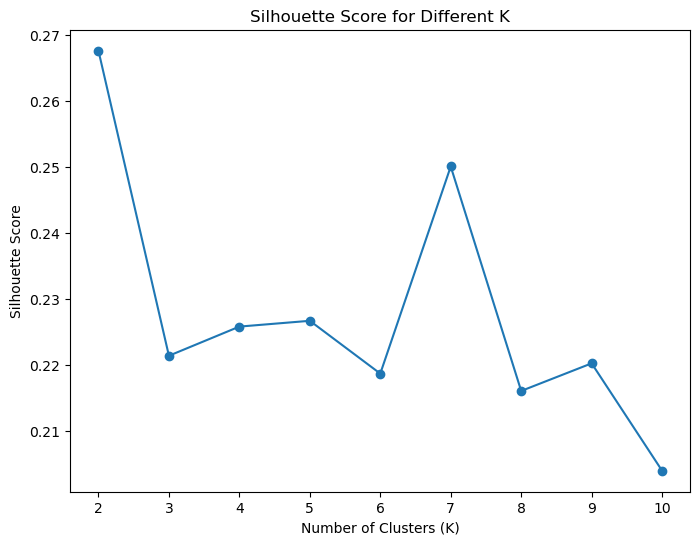

In [22]:
# Try different k values and select the best one using silhouette score
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(x)
    silhouette_scores.append(silhouette_score(x, kmeans.labels_))

# Plot the silhouette scores to find the optimal k
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K')
plt.show()

Apply kmeans clustering for n = 2

In [23]:
# Fit the model
kmeans = KMeans(n_clusters = 2, random_state = 123, n_init=10) 
kmeans.fit(x)                                           
clust_km_sil = pd.Series(kmeans.labels_)

#### 5. Plot the clusters.

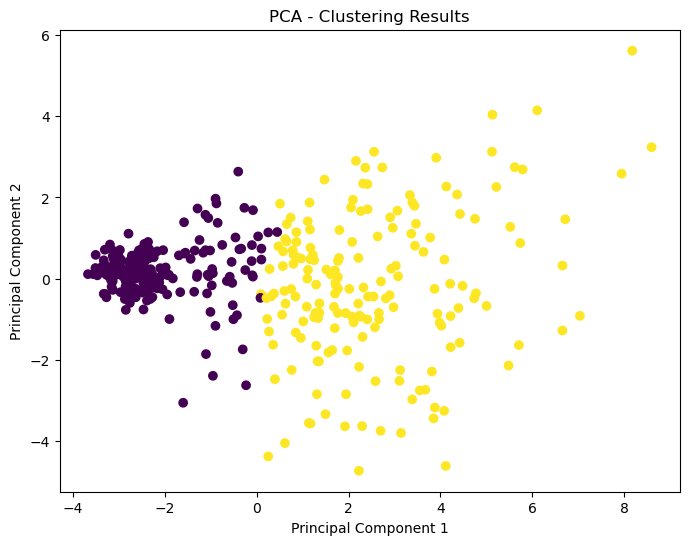

In [24]:
# Apply PCA to reduce data to 2D
pca = PCA(n_components=2)
pca_km_sil = pca.fit_transform(x)

# Visualize the clustered data using a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_km_sil[:, 0], pca_km_sil[:, 1], c=clust_km_sil)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA - Clustering Results")
plt.show()